# K-Means Iris dataset

In [235]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import mode
import numpy as np
from sklearn.metrics import silhouette_score



In [236]:
RANDOM_SEED = 9
DATASPLIT = 0.3
DATASET_ID= 109

In [237]:
logger = logging.getLogger(str(DATASET_ID))
logging.basicConfig(level=logging.DEBUG)

In [238]:
dataset = fetch_ucirepo(id=DATASET_ID)

df = pd.DataFrame(dataset.data.features)

label_encoder = LabelEncoder()

df['class'] = label_encoder.fit_transform(dataset.data.targets)

df = df.replace("?", pd.NA).dropna()

scaler = StandardScaler()

data = scaler.fit_transform(df)

labels = df['class']

df = df.drop(columns=['class'])



data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=DATASPLIT, random_state=RANDOM_SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=DATASPLIT, random_state=RANDOM_SEED)

logger.info(f"Train dataset length: {len(data_train)}, Validation dataset length: {len(data_val)}, Test dataset length: {len(data_test)}")

print(df.head())




/home/hedlund01/SynologyDrive/LTU/D7041E/Miniproject/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:109:Train dataset length: 86, Validation dataset length: 38, Test dataset length: 54


   Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  
0                        

In [239]:
parameters = {
    'n_clusters': range(2, 10, 1),
    'max_iter': range(100, 500, 100),
}


clf = GridSearchCV(KMeans(random_state=RANDOM_SEED), parameters, scoring='accuracy', verbose=0)
clf.fit(data_val, label_val)

model = clf.best_estimator_
logger.info("Best cross-validation score: %f", clf.best_score_)
logger.info("With parameters: %s", clf.best_params_)

logger.info("Training model with best parameters")
model.fit(data_train, label_train)

predictions = model.predict(data_test)

   
mapped_labels = np.zeros_like(predictions)
for i in range(clf.best_params_['n_clusters']):  
    mask = (predictions == i)
    mapped_labels[mask] = mode(label_test[mask])[0]



accuracy = accuracy_score(label_test, mapped_labels)
logger.info("Accuracy: %f", accuracy)

f1 = f1_score(label_test, mapped_labels, average='weighted')
logger.info("F1 score: %f", f1)

ari = adjusted_rand_score(label_test, mapped_labels)
logger.info("ARI score: %f", ari)

sil = silhouette_score(data_test, mapped_labels)
logger.info("Silhouette score: %f", sil)


INFO:109:Best cross-validation score: 0.360714
INFO:109:With parameters: {'max_iter': 100, 'n_clusters': 2}
INFO:109:Training model with best parameters
INFO:109:Accuracy: 0.722222
INFO:109:F1 score: 0.615385
INFO:109:ARI score: 0.508650
INFO:109:Silhouette score: 0.355527


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7dd3499e8170>


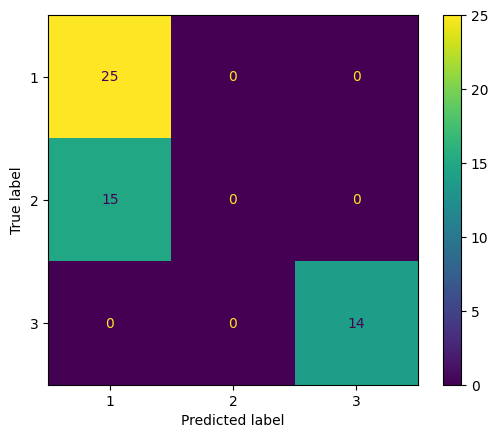

In [240]:
cm = confusion_matrix(label_test, mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


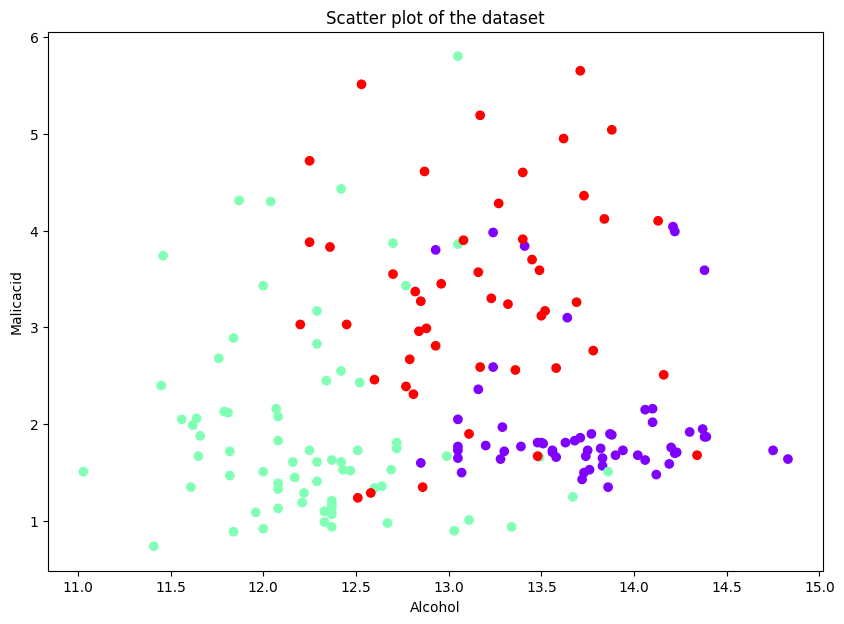

In [241]:

plt.figure(figsize=(10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='rainbow')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Scatter plot of the dataset")
plt.show()